In [1]:
import pandas as pd
import warnings
import numpy as np
from numpy import NaN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [2]:
url = "https://raw.githubusercontent.com/AndresBeta123/ProyectoDataMining-2023/main/principals_complete_preprocesado.csv"
principals_complete_preprocesado = pd.read_csv(url)

In [3]:
url = "https://raw.githubusercontent.com/AndresBeta123/ProyectoDataMining-2023/main/title_complete_preprocesado.csv"
title_complete_preprocesado = pd.read_csv(url)

In [4]:
def generarMatrizDeAsociacion(data):
    all_items = set()
    for items_str in data:
        items_list = [item.strip() for item in items_str.split(',')]
        all_items.update(items_list)

    # Crear un diccionario para almacenar los datos
    data_dict = {}
    for item in all_items:
        data_dict[item] = []

    # Llenar el diccionario con los valores True/False
    for items_str in data:
        items_list = [item.strip() for item in items_str.split(',')]
        for item in all_items:
            data_dict[item].append(1 if item in items_list else 0)

    # Crear un DataFrame a partir del diccionario
    return pd.DataFrame(data_dict)

In [5]:
editable_principals = principals_complete_preprocesado.copy()
editable_principals = editable_principals[editable_principals['category'] != 'self']

merge_df = pd.merge(editable_principals,title_complete_preprocesado,on='tconst',how = 'right')
editable_principals['averageRating'] = merge_df['averageRating']
editable_principals = editable_principals.dropna()

In [6]:
promedio_por_actor = editable_principals.groupby('nconst')['averageRating'].mean().reset_index()
promedio_por_actor
promedio_por_actor.columns = ['averageRatingCast' if col == 'averageRating' else col for col in promedio_por_actor.columns]
merge_df = pd.merge(editable_principals,promedio_por_actor,on='nconst',how = 'right')

promedio_por_pelicula = merge_df.groupby('tconst')['averageRatingCast'].mean().reset_index()


In [7]:
merge_df = pd.merge(title_complete_preprocesado,promedio_por_pelicula,on='tconst',how='right')
merge_df.dropna(subset=['genres'], inplace=True)
encodeMatrix = generarMatrizDeAsociacion(merge_df['genres'])
merge_df=merge_df.drop(['primaryTitle','genres','category 1','category 2','category 3'],axis=1)

In [8]:
merge_df.reset_index(drop=True, inplace=True)
encodeMatrix.reset_index(drop=True, inplace=True)
# Unir las tablas basándote en el índice
dataSetClasificacion = pd.concat([merge_df, encodeMatrix], axis=1)
dataSetClasificacion = dataSetClasificacion.drop(['tconst'],axis= 1)
display(dataSetClasificacion)

,startYear,runtimeMinutes,averageRating,numVotes,averageRatingCast,War,Reality-TV,Biography,Animation,Sport,...,Documentary,Film-Noir,Thriller,Mystery,Musical,Action,Adventure,Romance,Fantasy,Talk-Show
0,1894.0,0.000856,0.477778,7.174553e-05,0.500000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1897.0,0.001925,0.477778,1.703956e-04,0.588889,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,1906.0,0.001342,0.555556,3.006138e-04,0.591667,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1907.0,0.001731,0.377778,5.380915e-06,0.579630,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1907.0,0.001731,0.366667,6.815826e-06,0.514815,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264896,2019.0,0.001011,0.700000,4.663460e-06,0.548889,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
264897,2020.0,0.001614,0.533333,5.129806e-04,0.506502,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
264898,2020.0,0.001770,0.600000,1.966186e-03,0.592815,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264899,2019.0,0.001731,0.288889,3.946004e-06,0.568519,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Arbol de decisiones

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    title = 'Matriz de Confusión'
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta Verdadera',
           xlabel='Etiqueta Predicha')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="red" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [10]:
def medidasDeCalidad(y_pred,y_test,class_names):
  # Confusion Matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:")
  print(conf_matrix)
  plot_confusion_matrix(y_test,y_pred,classes=class_names)
  # Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)

  # Classification Error
  error = 1 - accuracy
  print("Classification Error:", error)

In [11]:
bins = [0, 0.25, 0.5, 0.75, 1.0]
labels = ['muy Mala', 'mala', 'buena', 'muy Buena',]
dataSetClasificacionDT = dataSetClasificacion.copy()
# Discretizar la columna en 4 bins
dataSetClasificacionDT['averageRating'] = pd.cut(dataSetClasificacionDT['averageRating'], bins=bins, labels=labels, include_lowest=True)


X = dataSetClasificacionDT.drop('averageRating', axis=1)
Y = dataSetClasificacionDT['averageRating']

#Se parten los datos para usar 70 Entrenamiento y 30 test:
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(X, Y,
                                                    test_size=.3)

In [12]:
depths = range(1, 15)
train_errors = []
test_errors = []

for depth in depths:
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=1)
    clf.fit(X_train_db, y_train_db)

    # Predicciones en conjuntos de entrenamiento y prueba
    y_train_pred = clf.predict(X_train_db)
    y_test_pred = clf.predict(X_test_db)

    # Calcular errores de entrenamiento y prueba
    train_errors.append(1 - accuracy_score(y_train_db, y_train_pred))
    test_errors.append(1 - accuracy_score(y_test_db, y_test_pred))

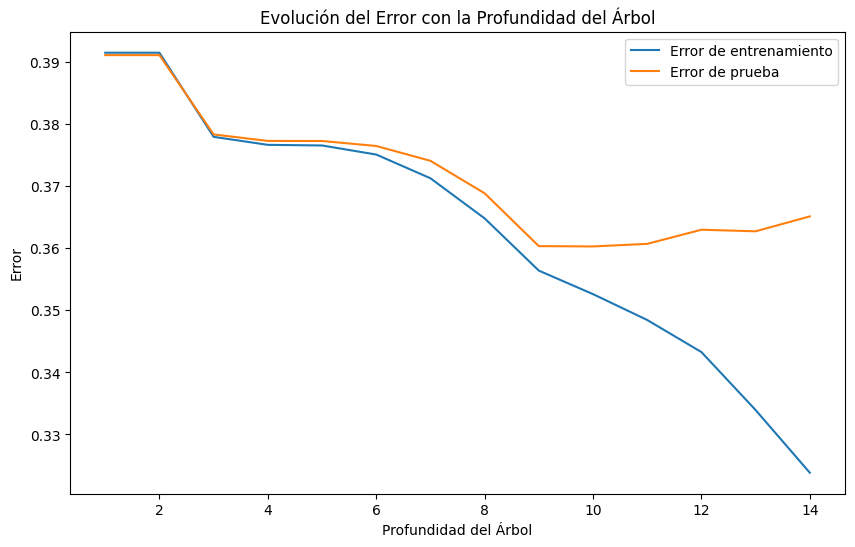

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(depths, train_errors, label='Error de entrenamiento')
plt.plot(depths, test_errors, label='Error de prueba')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Error')
plt.title('Evolución del Error con la Profundidad del Árbol')
plt.legend()
plt.show()

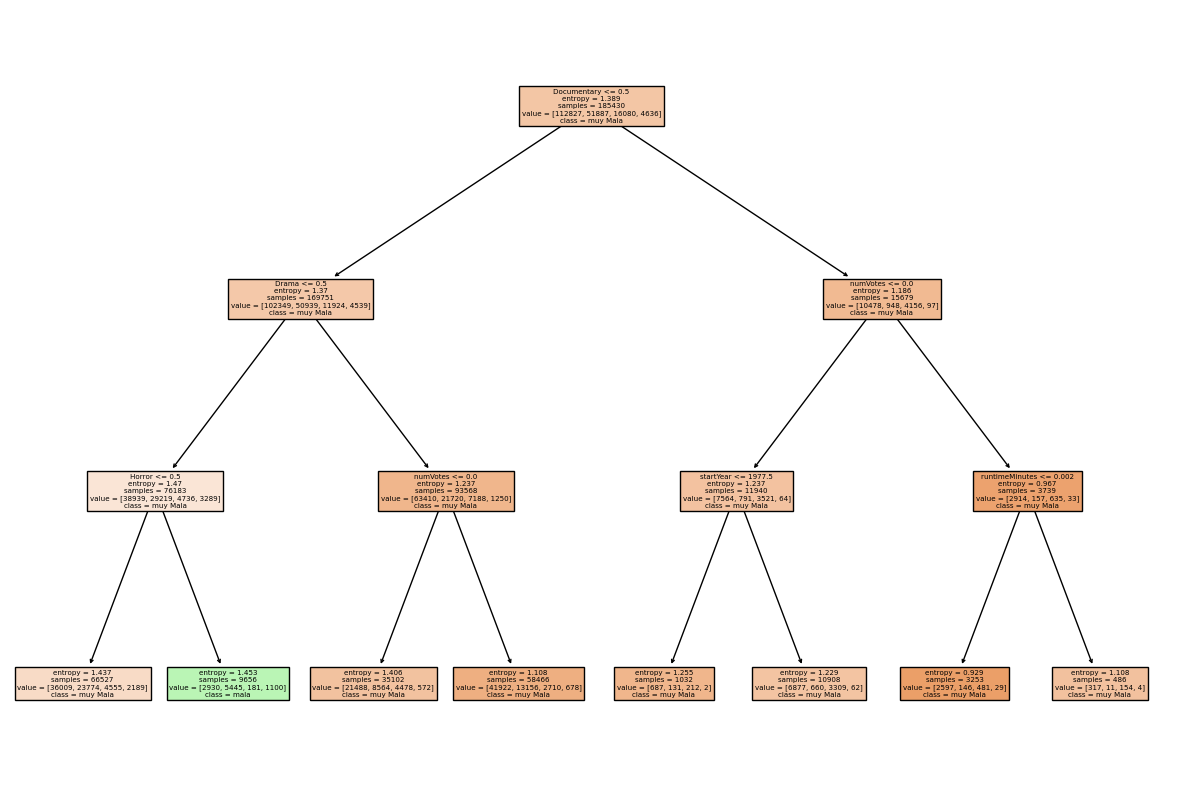

In [14]:
clf = tree.DecisionTreeClassifier(criterion = "entropy",max_depth=3)
clf = clf.fit(X_train_db, y_train_db)

column_labels = X.columns.to_numpy()
fig, ax = plt.subplots(figsize=(15, 10))
pl = tree.plot_tree(clf,filled=True,feature_names = column_labels,ax=ax,class_names = labels)
plt.show()

Confusion Matrix:
[[44487  3699   199     1]
 [16002  6105    21     0]
 [ 6636   129   242     1]
 [ 1081   866     1     1]]
Accuracy: 0.6396673000213915
Classification Error: 0.3603326999786085


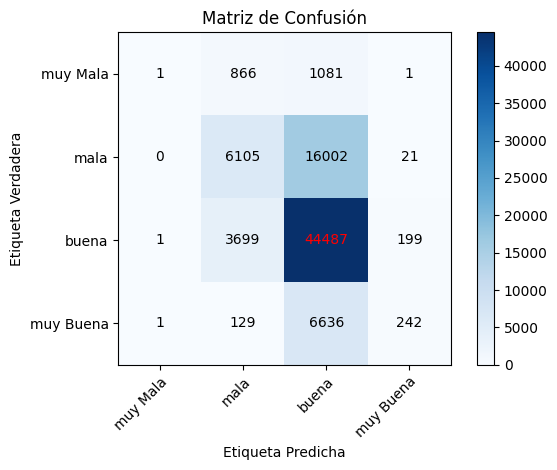

In [105]:
clf = tree.DecisionTreeClassifier(criterion = "entropy",max_depth=9)
clf = clf.fit(X_train_db, y_train_db)
y_pred = clf.predict(X_test_db)
medidasDeCalidad(y_pred,y_test_db,labels)

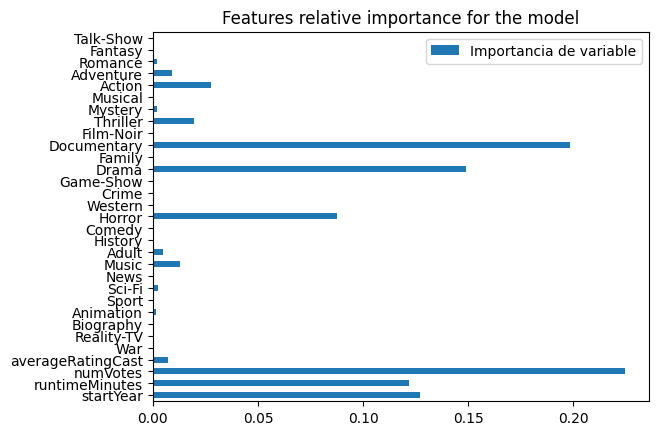

In [16]:
df_AD_imp = pd.DataFrame(clf.feature_importances_.reshape(1,-1), columns=X_train_db.columns, index=["Importancia de variable"])
df_AD_imp.T.plot.barh()
plt.legend()
plt.title("Features relative importance for the model")
plt.show()

# Naive Bayes


## Validación cruzada de tamaño 20

### Datos originales

In [17]:
X = dataSetClasificacionDT.drop('averageRating', axis=1)
y = dataSetClasificacionDT['averageRating']

# Naive Bayes convalidación cruzada de tamaño 20

nb_model = BernoulliNB()

nb_scores = cross_val_score(nb_model, X, y, cv=20)

print("Resultados del clasificador Naive Bayes:")
print("Precisión media:", nb_scores.mean())

nb_scores = cross_val_predict(nb_model, X, y, cv=20)


Resultados del clasificador Naive Bayes:
Precisión media: 0.6143994052892425


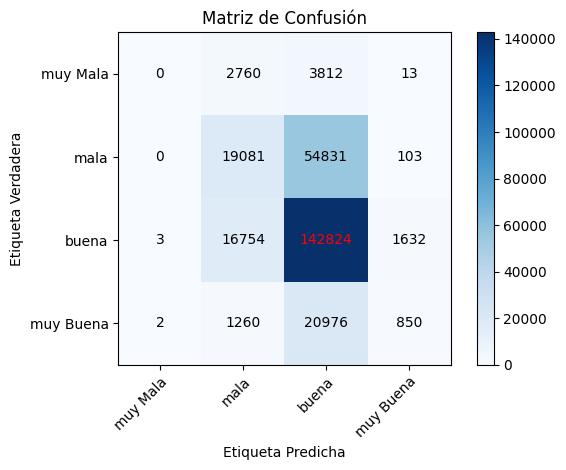

In [18]:
# Matriz de Confusión
plot_confusion_matrix(y, nb_scores, labels)
plt.show()

### Sobremuestro con SMOTE

In [19]:
X = dataSetClasificacionDT.drop('averageRating', axis=1)
y = dataSetClasificacionDT['averageRating']

# Submuestreo

# Sobremuestreo con SMOTE
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X, y)

conteo_clases = y.value_counts()
display(conteo_clases)

conteo_clases = y_resampled.value_counts()
display(conteo_clases)

averageRating
buena        161213
mala          74015
muy Buena     23088
muy Mala       6585
Name: count, dtype: int64

averageRating
muy Mala     161213
mala         161213
buena        161213
muy Buena    161213
Name: count, dtype: int64

In [20]:
# Naive Bayes convalidación cruzada de tamaño 20

nb_model = BernoulliNB()

nb_scores = cross_val_score(nb_model, X_resampled, y_resampled, cv=20)

print("Resultados del clasificador Naive Bayes:")
print("Precisión media:", nb_scores.mean())

nb_scores = cross_val_predict(nb_model, X_resampled, y_resampled, cv=20)


Resultados del clasificador Naive Bayes:
Precisión media: 0.4466202297221515


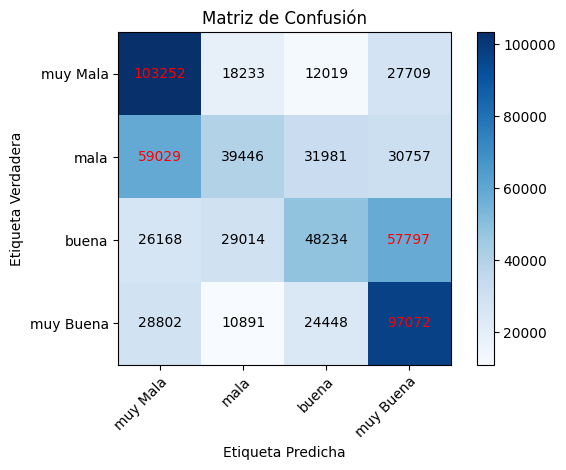

In [21]:
# Matriz de Confusión
plot_confusion_matrix(y_resampled, nb_scores, labels)
plt.show()

## 70 - 30

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

nb_model = BernoulliNB()

# Entrenamiento
nb_model.fit(X_train, y_train)

# Predicciones
y_pred = nb_model.predict(X_test)

# Precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo en el conjunto de prueba: {accuracy:.4f}')

Precisión del modelo en el conjunto de prueba: 0.6144


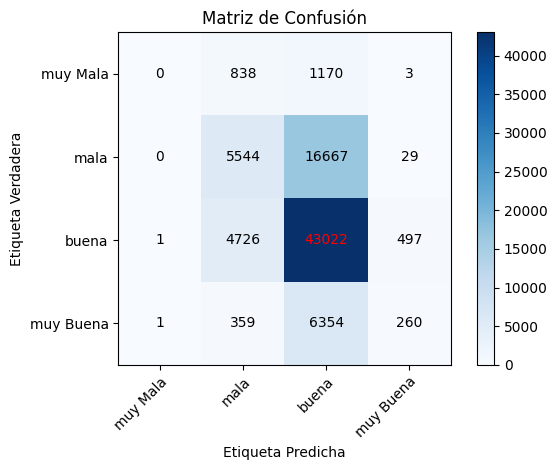

In [23]:
# Matriz de Confusión
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

# Red Neuronal 

## Sin mayores cambios al dataset

In [78]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import Model

TensorFlow version: 2.16.0-dev20231201


In [79]:
input_layer = tf.keras.layers.Input(shape=(31,))
model = tf.keras.models.Sequential([
    
  input_layer,
  tf.keras.layers.Dense(72, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 72)                │      2,304 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 32)                │      2,336 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 16)                │        528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 4)                 │         68 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 5,236 (20.45 KB)

 Trainable params: 5,236 (20.45 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
bins = [0, 0.25, 0.5, 0.75, 1.0]
labels = ['muy Mala', 'mala', 'buena', 'muy Buena',]
dataSetClasificacionDT = dataSetClasificacion.copy()
# Discretizar la columna en 4 bins
dataSetClasificacionDT['averageRating'] = pd.cut(dataSetClasificacionDT['averageRating'], bins=bins, labels=labels, include_lowest=True)


X = dataSetClasificacionDT.drop('averageRating', axis=1)
Y = dataSetClasificacionDT['averageRating']
Y = pd.get_dummies(Y)
y = dataSetClasificacionDT['averageRating'] 


In [101]:

conteo_clases = Y.copy()

conteo_clases = conteo_clases.idxmax(axis=1)
conteo_clases = conteo_clases.value_counts()
conteo_clases = pd.DataFrame(conteo_clases)
display(conteo_clases)

,count
buena,161213
mala,74015
muy Buena,23088
muy Mala,6585


In [81]:

#Se parten los datos para usar 70 Entrenamiento y 30 test:
X_train_rn, X_test_rn, y_train_rn, y_test_rn = train_test_split(X, Y,
                                                    test_size=.3)

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_rn, y_train_rn, epochs=10, batch_size=32, validation_data=(X_test_rn, y_test_rn))

Epoch 1/10
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 5s 739us/step - accuracy: 0.5148 - loss: 2.1402 - val_accuracy: 0.5119 - val_loss: 1.0338
Epoch 2/10
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 4s 726us/step - accuracy: 0.5922 - loss: 1.0219 - val_accuracy: 0.6085 - val_loss: 0.9723
Epoch 3/10
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 4s 707us/step - accuracy: 0.6086 - loss: 0.9587 - val_accuracy: 0.6154 - val_loss: 0.9345
Epoch 4/10
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 4s 718us/step - accuracy: 0.6131 - loss: 0.9412 - val_accuracy: 0.6179 - val_loss: 0.9230
Epoch 5/10
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 4s 725us/step - accuracy: 0.6181 - loss: 0.9186 - val_accuracy: 0.6197 - val_loss: 0.9072
Epoch 6/10
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 4s 745us/step - accuracy: 0.6204 - loss: 0.9111 - val_accuracy: 0.6234 - val_loss: 0.9145
Epoch 7/10
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 4s 764us/step - accuracy: 0.6210 - loss: 0.9076 - val_accuracy: 0.6233 - val_loss: 0.9030
Epoch 8/10
5795/5795 ━━━━━━━━━━━━━━━━━━━━ 4s 767us/step - accuracy: 0.6233 -

In [83]:
loss, accuracy = model.evaluate(X_test_rn, y_test_rn)
print(f'Loss: {loss}, Accuracy: {accuracy}')

   1/2484 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.4688 - loss: 0.8867

2484/2484 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - accuracy: 0.6164 - loss: 0.9243
Loss: 0.9219359159469604, Accuracy: 0.6174957156181335


In [100]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


Under_sampler = RandomOverSampler(sampling_strategy='minority')
X_under, y_under = Under_sampler.fit_resample(X, y)
y_under =pd.get_dummies(y_under)

Over_sampler = RandomUnderSampler(sampling_strategy='majority')
X_Over, y_Over = Over_sampler.fit_resample(X, y)
y_Over =pd.get_dummies(y_Over)


conteo_clases = y_under.copy()

conteo_clases = conteo_clases.idxmax(axis=1)
conteo_clases = conteo_clases.value_counts()
conteo_clases = pd.DataFrame(conteo_clases)
display(conteo_clases)

conteo_clases = y_Over.copy()
conteo_clases = conteo_clases.idxmax(axis=1)
conteo_clases = conteo_clases.value_counts()
conteo_clases = pd.DataFrame(conteo_clases)
display(conteo_clases)

,count
muy Mala,161213
buena,161213
mala,74015
muy Buena,23088


,count
mala,74015
muy Buena,23088
muy Mala,6585
buena,6585


## Con Over Sampling minority

In [85]:

#Se parten los datos para usar 70 Entrenamiento y 30 test:
X_train_U, X_test_U, y_train_U, y_test_U = train_test_split(X_under, y_under,
                                                    test_size=.3)

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_U, y_train_U, epochs=10, batch_size=32, validation_data=(X_test_U, y_test_U))

Epoch 1/10
9178/9178 ━━━━━━━━━━━━━━━━━━━━ 8s 759us/step - accuracy: 0.5096 - loss: 1.1422 - val_accuracy: 0.5240 - val_loss: 1.0938
Epoch 2/10
9178/9178 ━━━━━━━━━━━━━━━━━━━━ 7s 752us/step - accuracy: 0.5388 - loss: 1.0892 - val_accuracy: 0.5440 - val_loss: 1.0810
Epoch 3/10
9178/9178 ━━━━━━━━━━━━━━━━━━━━ 7s 744us/step - accuracy: 0.5404 - loss: 1.0883 - val_accuracy: 0.5488 - val_loss: 1.0787
Epoch 4/10
9178/9178 ━━━━━━━━━━━━━━━━━━━━ 7s 748us/step - accuracy: 0.5400 - loss: 1.0870 - val_accuracy: 0.5473 - val_loss: 1.0849
Epoch 5/10
9178/9178 ━━━━━━━━━━━━━━━━━━━━ 7s 747us/step - accuracy: 0.5404 - loss: 1.0849 - val_accuracy: 0.5392 - val_loss: 1.0844
Epoch 6/10
9178/9178 ━━━━━━━━━━━━━━━━━━━━ 7s 745us/step - accuracy: 0.5435 - loss: 1.0834 - val_accuracy: 0.5491 - val_loss: 1.0741
Epoch 7/10
9178/9178 ━━━━━━━━━━━━━━━━━━━━ 7s 747us/step - accuracy: 0.5436 - loss: 1.0819 - val_accuracy: 0.5497 - val_loss: 1.0768
Epoch 8/10
9178/9178 ━━━━━━━━━━━━━━━━━━━━ 7s 751us/step - accuracy: 0.5411 -

In [87]:
loss, accuracy = model.evaluate(X_test_rn, y_test_rn)
print(f'Loss: {loss}, Accuracy: {accuracy}')

   1/2484 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.3750 - loss: 1.2841

2484/2484 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step - accuracy: 0.4567 - loss: 1.2425
Loss: 1.2400151491165161, Accuracy: 0.45853203535079956


## Con under Sampling majority

In [88]:

#Se parten los datos para usar 70 Entrenamiento y 30 test:
X_train_U, X_test_U, y_train_U, y_test_U = train_test_split(X_Over, y_Over,
                                                    test_size=.3)

In [89]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_U, y_train_U, epochs=10, batch_size=32, validation_data=(X_test_U, y_test_U))

Epoch 1/10


2413/2413 ━━━━━━━━━━━━━━━━━━━━ 3s 793us/step - accuracy: 0.6567 - loss: 0.9151 - val_accuracy: 0.7144 - val_loss: 0.8313
Epoch 2/10
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.7141 - loss: 0.8339 - val_accuracy: 0.7160 - val_loss: 0.8317
Epoch 3/10
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - accuracy: 0.7129 - loss: 0.8325 - val_accuracy: 0.7149 - val_loss: 0.8273
Epoch 4/10
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 2s 764us/step - accuracy: 0.7142 - loss: 0.8283 - val_accuracy: 0.7154 - val_loss: 0.8288
Epoch 5/10
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 2s 767us/step - accuracy: 0.7169 - loss: 0.8257 - val_accuracy: 0.7165 - val_loss: 0.8302
Epoch 6/10
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.7143 - loss: 0.8283 - val_accuracy: 0.7133 - val_loss: 0.8530
Epoch 7/10
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 2s 747us/step - accuracy: 0.7151 - loss: 0.8265 - val_accuracy: 0.7144 - val_loss: 0.8358
Epoch 8/10
2413/2413 ━━━━━━━━━━━━━━━━━━━━ 2s 763us/step - accuracy: 0.7132 - loss: 0.83

In [90]:
loss, accuracy = model.evaluate(X_test_rn, y_test_rn)
print(f'Loss: {loss}, Accuracy: {accuracy}')

   1/2484 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.4062 - loss: 1.7068

2484/2484 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - accuracy: 0.2990 - loss: 1.7565
Loss: 1.75910222530365, Accuracy: 0.29741665720939636
